In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preprocess import Preprocess
from ProbabilisticMatrixFactorization import PMF
import tensorflow as tf
import rrn

import matplotlib.pyplot as plt

/Users/larry/Py3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('rating_data.csv')
df['freq'] = df.groupby('uid')['uid'].transform('count')  # count frequncy by column's values
df = df[df['freq'] > 5]  # remove row which corresponding frequence < 5

In [3]:
import math
def get_map(list_):
    map_ = {}
    for idx, ident in enumerate(list_):
        map_[ident] = idx
        
    return map_

def train_test_split(df, split_rate= 0.125):
    time_interval = 3 * 30 * 24 *3600
    start_time = min(df['timestamp'])
    end_time = max(df['timestamp'])
    time_elapse = (end_time-start_time) // time_interval
    split_time = start_time + math.floor(time_elapse * (1-split_rate)) * time_interval
    
    df_train = df[df['timestamp'] < split_time]
    df_test = df[df['timestamp'] >= split_time]
    
    return df_train, df_test

In [4]:
userList = np.unique(df['uid'])
itemList = np.unique(df['iid'])
user_map = get_map(userList)
item_map = get_map(itemList)
initial_time = min(df['timestamp'])

df_train, df_test = train_test_split(df)

for season_idx in range(ground_truth.shape[0]):
    for usr_idx in range(ground_truth.shape[1]):
        for item_idx in range(ground_truth.shape[2]):
            usr = preprocess.user_map[batch_user[usr_idx]]
            item = batch_item[item_idx] - 1
            try:
                assert ground_truth[season_idx][usr_idx][item_idx] == usr_matrix[usr_idx][season_idx][item]
            except AssertionError:
                print ("season_idx, usr_idx, item_idx: %d, %d, %d" % (season_idx, usr_idx, item))
            try:
                assert ground_truth[season_idx][usr_idx][item_idx] == item_matrix[item_idx][season_idx][usr]
            except AssertionError:
                print ("season_idx, usr, item_idx: %d, %d, %d" % (season_idx, usr, item_idx))

In [5]:
def get_hparas(name):
    if name == 'USER':
        hparas = {
            'NAME': name,
            'EMBED_UNITS': 40,
            'BATCH_SIZE': 64,
            'LSTM_UNITS': 40,
            'LATENT_UNITS': 20,
            'ITEM_NUM': 102,
            'TRAIN_TIME_ELAPSE': 21,
            'TEST_TIME_ELAPSE': 3,
            'STATIONARY_LENGTH': 20,
        }
    elif name == 'ITEM':
        hparas = {
            'NAME': name,
            'EMBED_UNITS': 40,
            'BATCH_SIZE': 64,
            'LATENT_UNITS': 20,
            'LSTM_UNITS': 40,
            'TRAIN_TIME_ELAPSE': 21,
            'TEST_TIME_ELAPSE': 3,
            'USER_NUM': 842,
            'STATIONARY_LENGTH': 20
        }
    
    return hparas

## Use PMF prtrain User_vector, Item_vector

In [ ]:
def get_rating(df, user_map, item_map):
    df_ = df.as_matrix()
    prefer = []
    for line in df_:
        uid = user_map[line[0]]
        iid = item_map[line[1]]
        rat = float(line[2])
        prefer.append([uid, iid, rat])
    data = np.asarray(prefer)
    return data

In [ ]:
from sklearn.model_selection import train_test_split

rating = get_rating(df, user_map, item_map)
train_data, test_data = train_test_split(rating, test_size=0.2)

In [ ]:
pmf = PMF()
pmf.set_params({
    "num_feat": 20,
    "epsilon": 0.1,
    "_lambda": 0.01,
    "momentum": 0.8,
    "maxepoch": 200,
    "num_batches": 100,
    "batch_size": 1000
})

In [ ]:
pmf.fit(train_data, test_data)

In [ ]:
train_loss = pmf.rmse_train
test_loss = pmf.rmse_test

plt.plot(range(len(train_loss)), train_loss, color='blue', label='train loss')
plt.plot(range(len(test_loss)), test_loss, color='red', label='test loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

## LOG_LOSS with AdaGrad

user_hparas = get_hparas('USER')
item_hparas = get_hparas('ITEM')

tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_hparas, item_hparas=item_hparas, lr=0.01, epochs=200, loss_function='log_loss')

model.train(df, user_vectors, item_vectors)


train_loss = model.log['train_loss']

plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

## RMSE with Adam

In [6]:
user_vectors = np.load('user_vectors.npy')
item_vectors = np.load('item_vectors.npy')

user_hparas = get_hparas('USER')
item_hparas = get_hparas('ITEM')

In [7]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_hparas, item_hparas=item_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=True, lr=0.01, epochs=500, loss_function='rmse')

In [8]:
model.train(df_train, user_map, item_map, initial_time)

100%|██████████| 500/500 [01:39<00:00,  5.00it/s]


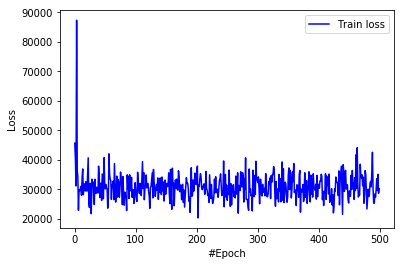

In [9]:
import matplotlib.pyplot as plt
train_loss = model.log['train_loss']

plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

In [10]:
model.model_saver(1)

In [11]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_hparas, item_hparas=item_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, lr=0.01, epochs=500, loss_function='rmse')

model.model_loader(2)

INFO:tensorflow:Restoring parameters from model/rrn_2.ckpt


In [12]:
test_loss = model.test(df_test, user_map, item_map, initial_time)

In [13]:
print (sum(test_loss)/len(test_loss))

0.669253116846


In [14]:
prep = Preprocess(df_test, user_map, item_map, initial_time)

user_input, item_input, ground_truth, batch_user, batch_item = prep.gen_batch(0)
u_static_vector = prep.get_latent_vector(batch_user, user_vectors, 'user')
i_static_vector = prep.get_latent_vector(batch_item, item_vectors, 'item')

In [15]:
output = model.sess.run(
    model.logits,
    feed_dict={
        model.user_input: user_input,
        model.item_input: item_input,
        model.user_stationary_factor: u_static_vector,
        model.item_stationary_factor: i_static_vector
    })

In [18]:
print (test_loss)

[0.77976966, 0.77736855, 0.59329259, 0.63651168, 0.56385636, 0.62020195, 0.6742937, 0.76971132, 0.6468699, 0.63065547]
